In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', None)



In [3]:
# Belgrade coordinates
lat, lon = 44.7866, 20.4489
start_date = "2023-01-01"
end_date = "2025-05-31"

# Add more hourly parameters
params = ",".join([
    "temperature_2m",
    "apparent_temperature",
    "precipitation",
    "rain",
    "snowfall",
    "cloudcover",
    "relative_humidity_2m",
    "windspeed_10m",
    "winddirection_10m",
    "windgusts_10m",
    "surface_pressure",
    "weathercode"
])

# Build API URL
url = (
    f"https://archive-api.open-meteo.com/v1/archive"
    f"?latitude={lat}&longitude={lon}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly={params}"
    f"&timezone=Europe%2FBelgrade"
)

# Request data
response = requests.get(url)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data['hourly'])
df['time'] = pd.to_datetime(df['time'])

# Show available columns
print(df.columns)
df.head()


Index(['time', 'temperature_2m', 'apparent_temperature', 'precipitation',
       'rain', 'snowfall', 'cloudcover', 'relative_humidity_2m',
       'windspeed_10m', 'winddirection_10m', 'windgusts_10m',
       'surface_pressure', 'weathercode'],
      dtype='object')


,time,temperature_2m,apparent_temperature,precipitation,rain,snowfall,cloudcover,relative_humidity_2m,windspeed_10m,winddirection_10m,windgusts_10m,surface_pressure,weathercode
0,2023-01-01 00:00:00,6.5,3.2,0.0,0.0,0.0,0,83,12.5,221,15.8,1009.3,0
1,2023-01-01 01:00:00,7.6,4.7,0.0,0.0,0.0,0,75,9.2,201,15.5,1009.6,0
2,2023-01-01 02:00:00,6.1,2.7,0.0,0.0,0.0,0,85,13.0,214,12.2,1009.2,0
3,2023-01-01 03:00:00,5.3,1.9,0.0,0.0,0.0,0,86,11.9,215,15.5,1009.3,0
4,2023-01-01 04:00:00,5.0,1.7,0.0,0.0,0.0,0,87,11.0,218,14.4,1009.1,0


In [5]:
lat, lon = 44.7866, 20.4489
start_date = "2025-06-23"
end_date = "2025-06-30"

# Hourly parameters
params = ",".join([
    "temperature_2m",
    "apparent_temperature",
    "precipitation",
    "rain",
    "snowfall",
    "cloudcover",
    "relative_humidity_2m",
    "windspeed_10m",
    "winddirection_10m",
    "windgusts_10m",
    "surface_pressure",
    "weathercode"
])

# Build API URL
url = (
    f"https://api.open-meteo.com/v1/forecast"
    f"?latitude={lat}&longitude={lon}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly={params}"
    f"&timezone=Europe%2FBelgrade"
)

# Request data
response = requests.get(url)
data = response.json()

future = pd.DataFrame(data['hourly'])
future['time'] = pd.to_datetime(future['time'])
future.head()

,time,temperature_2m,apparent_temperature,precipitation,rain,snowfall,cloudcover,relative_humidity_2m,windspeed_10m,winddirection_10m,windgusts_10m,surface_pressure,weathercode
0,2025-06-23 00:00:00,20.1,18.9,0.0,0.0,0.0,26,44,4.3,246,9.4,999.0,1
1,2025-06-23 01:00:00,19.3,18.0,0.0,0.0,0.0,38,47,4.9,234,9.7,998.8,1
2,2025-06-23 02:00:00,18.5,17.2,0.0,0.0,0.0,42,50,5.4,228,9.7,998.7,1
3,2025-06-23 03:00:00,17.5,16.1,0.0,0.0,0.0,32,53,5.6,225,8.3,998.3,1
4,2025-06-23 04:00:00,16.5,15.1,0.0,0.0,0.0,15,56,5.4,222,7.2,997.9,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29928 entries, 0 to 29927
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  29928 non-null  datetime64[ns]
 1   temperature_2m        29928 non-null  float64       
 2   apparent_temperature  29928 non-null  float64       
 3   precipitation         29928 non-null  float64       
 4   rain                  29928 non-null  float64       
 5   snowfall              29928 non-null  float64       
 6   cloudcover            29928 non-null  int64         
 7   relative_humidity_2m  29928 non-null  int64         
 8   windspeed_10m         29928 non-null  float64       
 9   winddirection_10m     29928 non-null  int64         
 10  windgusts_10m         29928 non-null  float64       
 11  surface_pressure      29928 non-null  float64       
 12  weathercode           29928 non-null  int64         
dtypes: datetime64[ns

In [13]:
df.describe()

,time,temperature_2m,apparent_temperature,precipitation,rain,snowfall,cloudcover,relative_humidity_2m,windspeed_10m,winddirection_10m,windgusts_10m,surface_pressure,weathercode
count,47472,47472.000000,47472.000000,47472.000000,47472.000000,47472.000000,47472.000000,47472.000000,47472.000000,47472.000000,47472.000000,47472.000000,47472.000000
mean,2022-09-15 23:30:00.000000256,12.820001,11.026222,0.079929,0.074117,0.004071,53.603429,71.414771,10.388629,197.298365,20.929563,997.069793,8.414918
min,2020-01-01 00:00:00,-14.500000,-20.300000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,1.000000,1.100000,969.800000,0.000000
25%,2021-05-09 11:45:00,5.600000,2.200000,0.000000,0.000000,0.000000,5.000000,59.000000,6.500000,119.000000,13.000000,992.300000,0.000000
50%,2022-09-15 23:30:00,12.600000,10.400000,0.000000,0.000000,0.000000,57.000000,74.000000,9.200000,201.000000,18.700000,996.500000,2.000000
75%,2024-01-23 11:15:00,19.700000,19.400000,0.000000,0.000000,0.000000,100.000000,86.000000,13.400000,282.000000,26.600000,1001.600000,3.000000
max,2025-05-31 23:00:00,37.800000,40.700000,19.900000,19.900000,2.240000,100.000000,100.000000,41.600000,360.000000,76.700000,1025.700000,75.000000
std,NaN,8.944285,10.767046,0.420846,0.413089,0.052819,42.316492,17.848106,5.647223,95.580827,10.310001,7.585280,18.240905


In [12]:
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  192 non-null    datetime64[ns]
 1   temperature_2m        192 non-null    float64       
 2   apparent_temperature  192 non-null    float64       
 3   precipitation         192 non-null    float64       
 4   rain                  192 non-null    float64       
 5   snowfall              192 non-null    float64       
 6   cloudcover            192 non-null    int64         
 7   relative_humidity_2m  192 non-null    int64         
 8   windspeed_10m         192 non-null    float64       
 9   winddirection_10m     192 non-null    int64         
 10  windgusts_10m         192 non-null    float64       
 11  surface_pressure      192 non-null    float64       
 12  weathercode           192 non-null    int64         
dtypes: datetime64[ns](1)

In [14]:
df.shape

(29928, 13)

In [16]:
df.isnull().sum()

time                    0
temperature_2m          0
apparent_temperature    0
precipitation           0
rain                    0
snowfall                0
cloudcover              0
relative_humidity_2m    0
windspeed_10m           0
winddirection_10m       0
windgusts_10m           0
surface_pressure        0
weathercode             0
dtype: int64

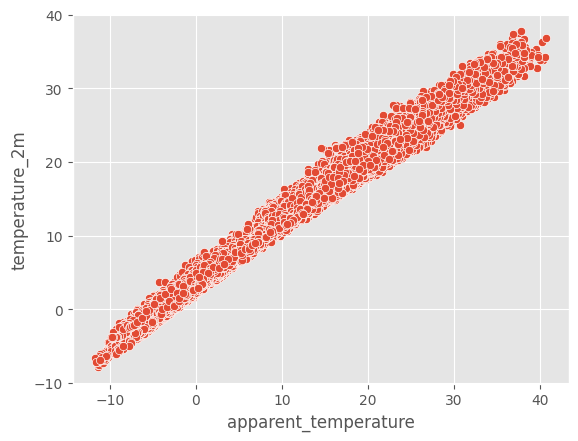

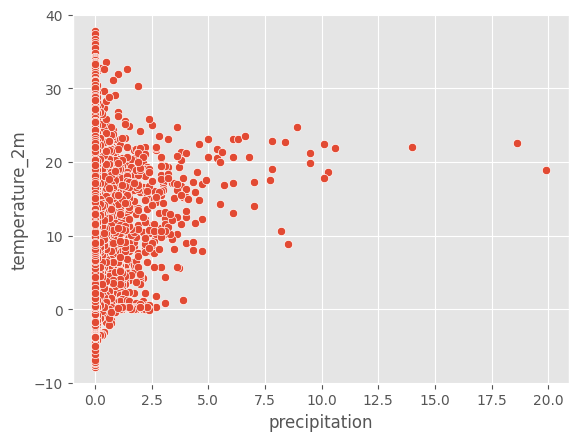

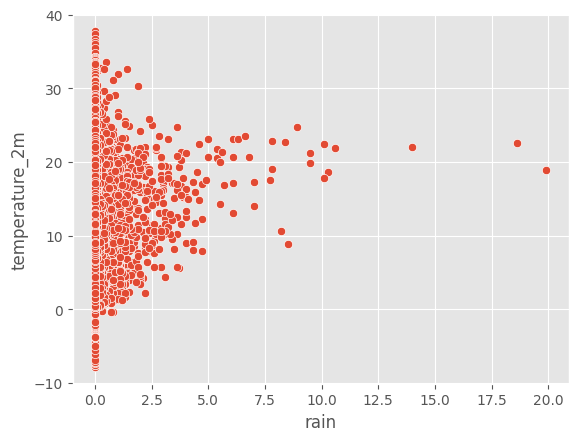

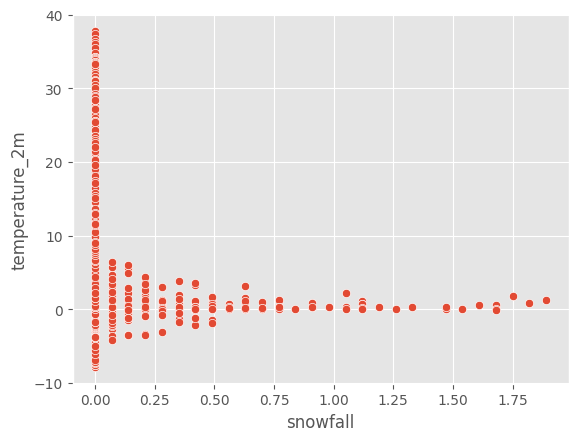

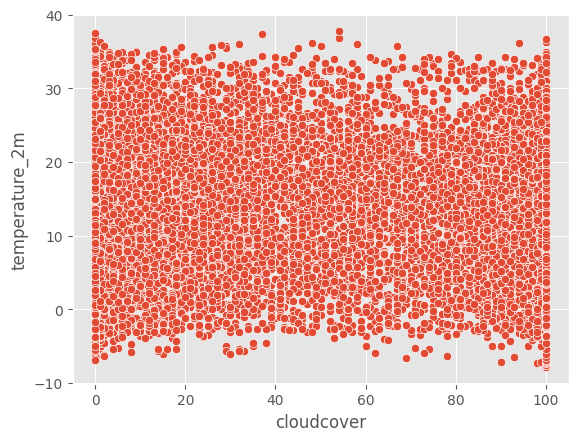

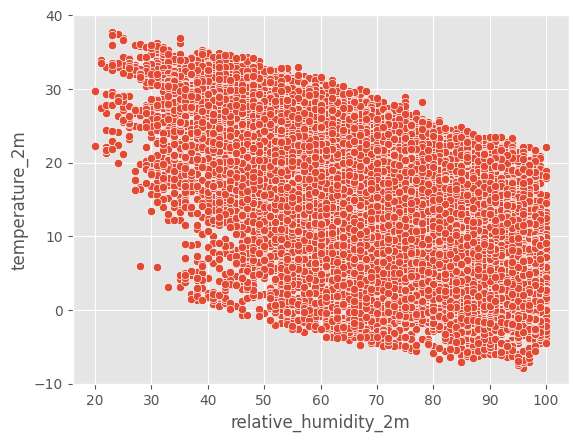

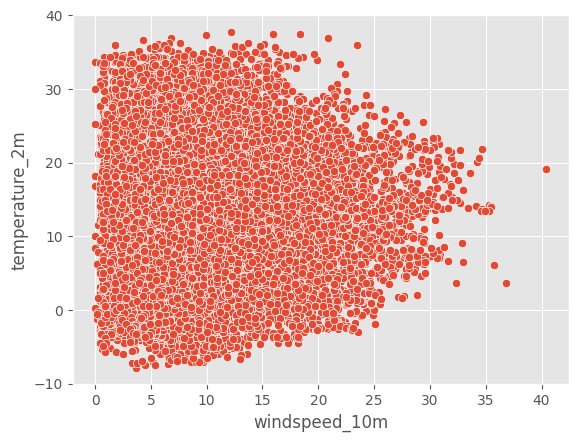

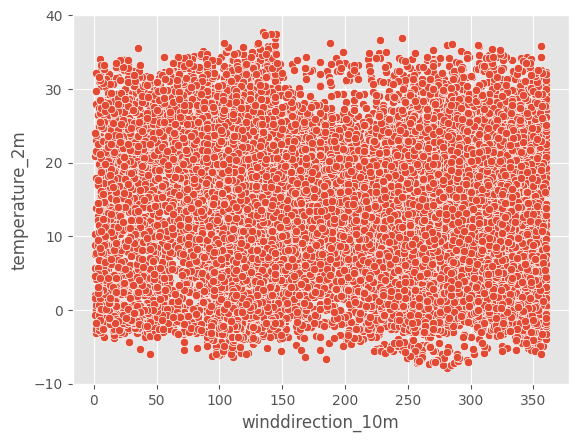

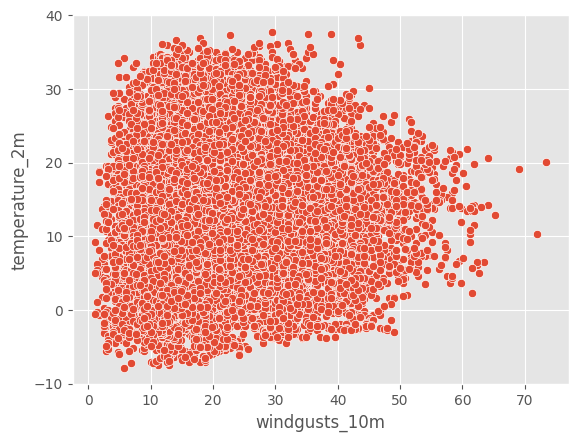

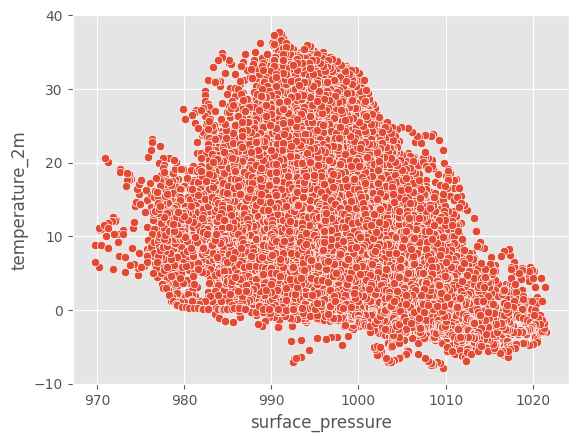

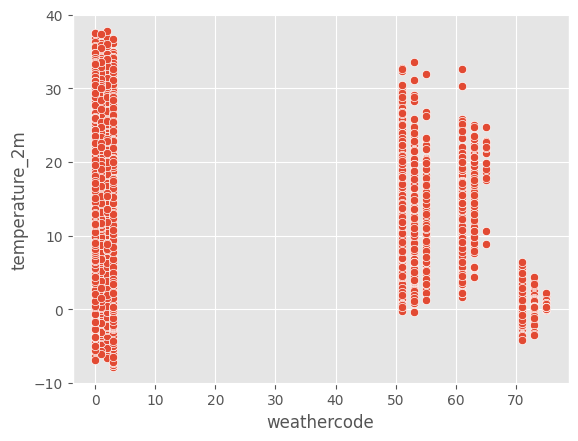

In [7]:
numeric=df.select_dtypes(include="number").drop('temperature_2m',axis=1)
for col in numeric:
    sns.scatterplot(data=df,x=col,y='temperature_2m')
    plt.show()

In [9]:
df.drop('weathercode',axis=1,inplace=True)
future.drop('weathercode',axis=1,inplace=True)

In [15]:
import datetime as dt
df['Year']=df['time'].dt.year
df['Month']=df['time'].dt.month
df['Hour']=df['time'].dt.hour
df.head(3)

,time,temperature_2m,apparent_temperature,precipitation,rain,snowfall,cloudcover,relative_humidity_2m,windspeed_10m,winddirection_10m,windgusts_10m,surface_pressure,Year,Month,Hour
0,2023-01-01 00:00:00,6.5,3.2,0.0,0.0,0.0,0,83,12.5,221,15.8,1009.3,2023,1,0
1,2023-01-01 01:00:00,7.6,4.7,0.0,0.0,0.0,0,75,9.2,201,15.5,1009.6,2023,1,1
2,2023-01-01 02:00:00,6.1,2.7,0.0,0.0,0.0,0,85,13.0,214,12.2,1009.2,2023,1,2


In [17]:
future['Year']=future['time'].dt.year
future['Month']=future['time'].dt.month
future['Hour']=future['time'].dt.hour

In [19]:
df.drop('time',axis=1,inplace=True)
future.drop('time',axis=1,inplace=True)

In [29]:
corr = df.corr()['temperature_2m'].drop('temperature_2m')
corr.sort_values(ascending=False)

apparent_temperature    0.991423
Month                   0.249414
Hour                    0.155774
windgusts_10m           0.041346
rain                    0.018059
precipitation          -0.001816
windspeed_10m          -0.030219
winddirection_10m      -0.065087
snowfall               -0.109644
Year                   -0.135122
cloudcover             -0.194681
surface_pressure       -0.389914
relative_humidity_2m   -0.562338
Name: temperature_2m, dtype: float64

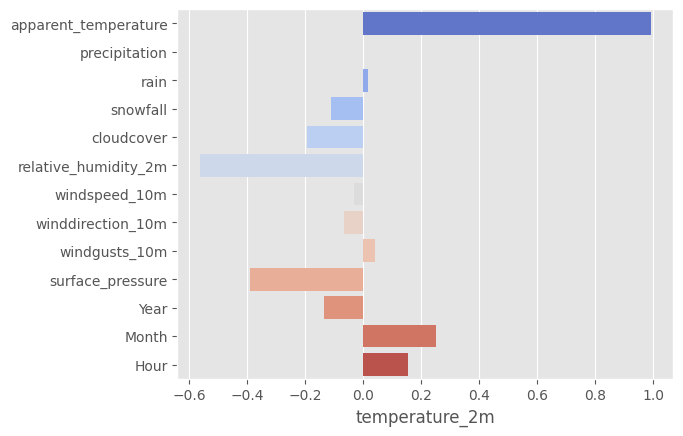

In [27]:
sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
plt.xlabel('temperature_2m')
plt.ylabel('')
plt.show()

In [33]:
df.drop('precipitation',axis=1,inplace=True)
future.drop('precipitation',axis=1,inplace=True)

In [35]:
X_train=df.drop('temperature_2m',axis=1)
y_train=df['temperature_2m']
X_test=future.drop('temperature_2m',axis=1)
y_test=future['temperature_2m']

In [37]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Coef: [ 8.48736272e+00 -3.06860135e-03 -1.27541756e-02  4.12892673e-02
 -7.88035437e-01  8.55835278e-01 -3.59680546e-03 -2.09170617e-01
 -1.22622407e-01  6.73383885e-02  7.45480382e-02  1.25193631e-02]
Intercept: 13.034693877551026
MSE 0.5766761761029944
R2:  0.9780773692313083
MAE:  0.6183496974714342


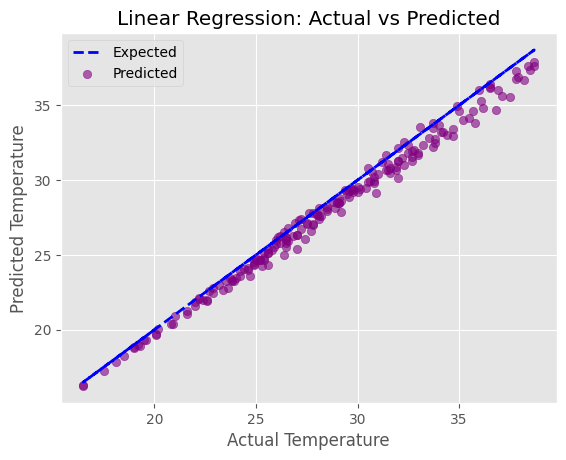

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Coef:',lr.coef_)
print('Intercept:',lr.intercept_)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('MSE', mse)
print('R2: ',r2)
print('MAE: ',mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred, color='purple', alpha=0.6, label='Predicted')

plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

Ridge Coef: [ 8.48654834e+00 -3.03193036e-03 -1.28112911e-02  4.11424928e-02
 -7.88324263e-01  8.55137228e-01 -3.63522357e-03 -2.08691684e-01
 -1.22944015e-01  6.72076541e-02  7.46788120e-02  1.25210659e-02]
Ridge Intercept: 13.034693877551026
Ridge MSE: 0.576998964590224
Ridge R2: 0.9780650982669177
Ridge MAE: 0.6186056816272177


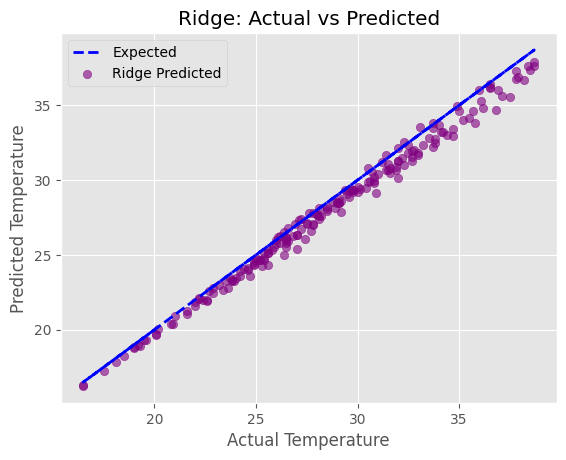

In [43]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print('Ridge Coef:', ridge.coef_)
print('Ridge Intercept:', ridge.intercept_)

r2 = r2_score(y_test, y_pred_ridge)
mae = mean_absolute_error(y_test, y_pred_ridge)
mse = mean_squared_error(y_test, y_pred_ridge)
print('Ridge MSE:', mse)
print('Ridge R2:', r2)
print('Ridge MAE:', mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_ridge, color='purple', alpha=0.6, label='Ridge Predicted')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Ridge: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

Lasso Coef: [ 8.41577336 -0.         -0.          0.         -0.71938242  0.57519932
 -0.          0.         -0.07997176  0.          0.          0.        ]
Lasso Intercept: 13.034693877551021
Lasso MSE: 0.9036979891295666
Lasso R2: 0.9656454728614308
Lasso MAE: 0.8336224099359847


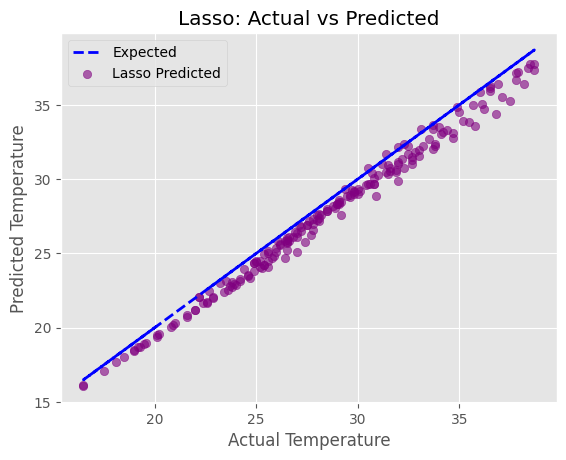

In [45]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

print('Lasso Coef:', lasso.coef_)
print('Lasso Intercept:', lasso.intercept_)

r2 = r2_score(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)
mse = mean_squared_error(y_test, y_pred_lasso)
print('Lasso MSE:', mse)
print('Lasso R2:', r2)
print('Lasso MAE:', mae)

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_lasso, color='purple', alpha=0.6, label='Lasso Predicted')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Lasso: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
print('Train: ',df.shape)
print('Test: ',future.shape)

Train:  (21168, 13)
Test:  (192, 13)


In [49]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(rf,param_grid,n_iter=50,               
    scoring='neg_mean_squared_error',cv=5,random_state=42,n_jobs=-1,verbose=2
)

random_search_rf.fit(X_train, y_train)

print("Best Params:", random_search_rf.best_params_)
print("Best R² score:", random_search_rf.best_score_)
print("Best RMSE:", (-random_search_rf.best_score_)**0.5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Best R² score: -1.0479802118626653
Best RMSE: 1.0237090464886327


Test R²: 0.632
Test MAE: 3
Test MSE: 9.668
RMSE: 3.11


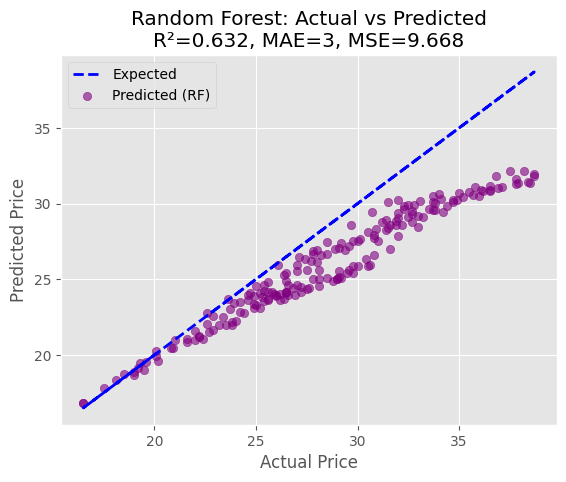

In [51]:
best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_rf, color='purple', alpha=0.6, label='Predicted (RF)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Random Forest: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
gbr= GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 300, 500],           
    'learning_rate': [0.01, 0.1, 0.2],             
    'max_depth': [5, 10, 15],                         
    'min_samples_split': [2, 5, 10],                    
    'min_samples_leaf': [1, 2, 4],                       
    'max_features': ['sqrt', 'log2'],                         
}

random_search_gbr = RandomizedSearchCV(gbr,param_grid,n_iter=30,               
    scoring='neg_mean_squared_error',cv=5,random_state=42,n_jobs=-1,verbose=2
)

random_search_gbr.fit(X_train, y_train)

print("Best Params:", random_search_gbr.best_params_)
print("Best R² score:", random_search_gbr.best_score_)
print("Best RMSE:", (-random_search_gbr.best_score_)**0.5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.1}
Best R² score: -0.47419414088611217
Best RMSE: 0.6886175577823384


Test R²: 0.964
Test MAE: 1
Test MSE: 0.955
RMSE: 0.98


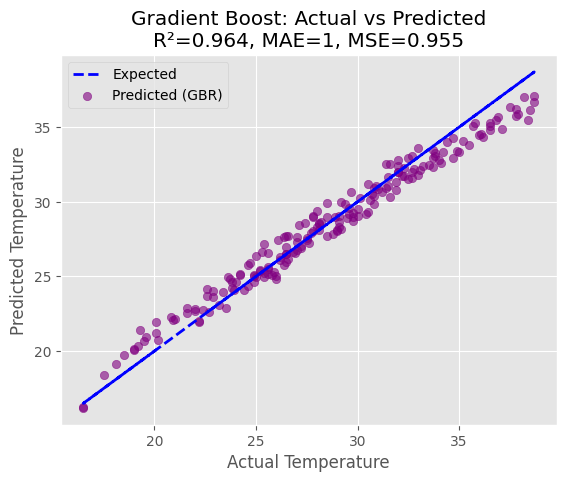

In [55]:
best_gbr = random_search_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)

r2 = r2_score(y_test, y_pred_gbr)
mae = mean_absolute_error(y_test, y_pred_gbr)
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_gbr, color='purple', alpha=0.6, label='Predicted (GBR)')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title(f'Gradient Boost: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'min_child_weight': [1, 3, 5],
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search_xgb = RandomizedSearchCV(xgb,param_grid,n_iter=50,scoring='neg_mean_squared_error',
    cv=5,verbose=1,n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

print("Best Params:", random_search_xgb.best_params_)
print("Best R² score:", random_search_xgb.best_score_)
print("Best RMSE:", (-random_search_xgb.best_score_)**0.5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0}
Best R² score: -0.047591291248155275
Best RMSE: 0.21815428313043794


Test R²: 0.988
Test MAE: 0
Test MSE: 0.323
RMSE: 0.57


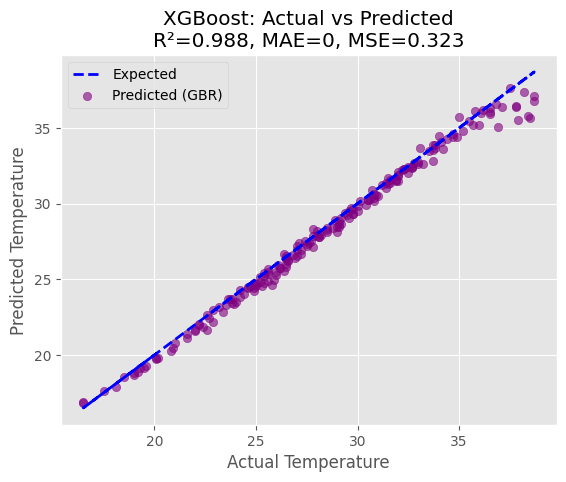

In [59]:
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_xgb, color='purple', alpha=0.6, label='Predicted (GBR)')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title(f'XGBoost: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
cat_param_grid = {'iterations': [300, 500, 700],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'random_strength': [0.5, 1, 2]
}

cat = CatBoostRegressor(verbose=0, random_state=42)

random_search_cat = RandomizedSearchCV(cat,cat_param_grid,n_iter=30,scoring='neg_mean_squared_error',
    cv=5,verbose=1,n_jobs=-1,random_state=42
)

random_search_cat.fit(X_train, y_train)
print("Best Params:", random_search_cat.best_params_)
print("Best Neg MSE:", random_search_cat.best_score_)
print("Best RMSE:", (-random_search_cat.best_score_) ** 0.5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'random_strength': 1, 'learning_rate': 0.2, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6, 'border_count': 128, 'bagging_temperature': 1.0}
Best Neg MSE: -0.08369986904202947
Best RMSE: 0.28930929650121767


Test R²: 0.980
Test MAE: 0
Test MSE: 0.536
RMSE: 0.73


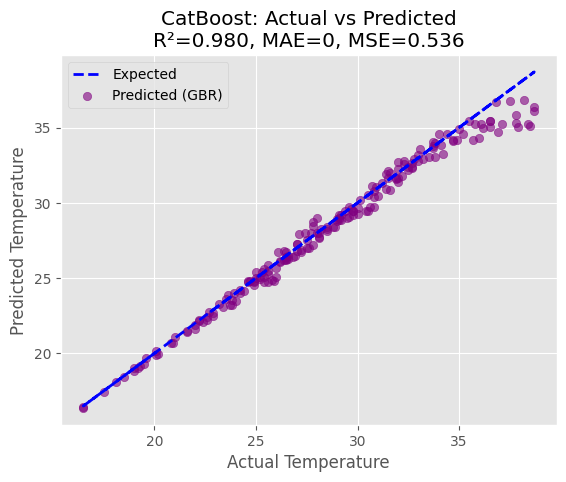

In [63]:
best_cat = random_search_cat.best_estimator_
y_pred_cat = best_cat.predict(X_test)

r2 = r2_score(y_test, y_pred_cat)
mae = mean_absolute_error(y_test, y_pred_cat)
mse = mean_squared_error(y_test, y_pred_cat)
rmse = np.sqrt(mse)

print(f"Test R²: {r2:.3f}")
print(f"Test MAE: {mae:,.0f}")
print(f"Test MSE: {mse:.3f}")
print(f"RMSE: {rmse:.2f}")

plt.plot(y_test, y_test, color='blue', linestyle='--', linewidth=2, label='Expected')
plt.scatter(y_test, y_pred_cat, color='purple', alpha=0.6, label='Predicted (GBR)')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title(f'CatBoost: Actual vs Predicted\nR²={r2:.3f}, MAE={mae:,.0f}, MSE={mse:.3f}')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
fitted_models = [
    ("Linear Regression", lr),
    ("Ridge Regression", ridge),
    ("Lasso Regression", lasso),
    ("Random Forest Regressor", best_rf),
    ("Gradient Boosting Regressor", best_gbr),
    ("XGBoost Regressor", best_xgb),
    ("CatBoost Regressor", best_cat),
    
]

results = []

for name, model in fitted_models:
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mse ** 0.5

    results.append({
        "Model": name,
        "Train R² Score": train_r2,
        "Test R² Score": test_r2,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae,
        "Root Mean Squared Error": rmse
    })

results_df = pd.DataFrame(results)
results_df

,Model,Train R² Score,Test R² Score,Mean Squared Error,Mean Absolute Error,Root Mean Squared Error
0,Linear Regression,0.997948,0.978077,0.576676,0.618350,0.759392
1,Ridge Regression,0.997948,0.978065,0.576999,0.618606,0.759604
2,Lasso Regression,0.997477,0.965645,0.903698,0.833622,0.950630
3,Random Forest Regressor,0.999742,0.632454,9.668325,2.584432,3.109393
4,Gradient Boosting Regressor,0.998867,0.963709,0.954626,0.804119,0.977050
5,XGBoost Regressor,0.999716,0.987738,0.322551,0.388225,0.567936
6,CatBoost Regressor,0.999769,0.979612,0.536315,0.464438,0.732335


In [69]:
prediction=future['temperature_2m'].copy()

In [73]:
prediction_df = y_test.to_frame()
prediction_df['temperature_2m_pred'] = best_xgb.predict(X_test)
prediction_df.head(10)

,temperature_2m,temperature_2m_pred
0,20.1,19.792938
1,19.3,19.126041
2,18.5,18.520359
3,17.5,17.592007
4,16.5,16.868387
5,16.5,16.845236
6,18.1,17.891344
7,20.9,20.436432
8,23.4,22.819082
9,25.3,24.547482
